In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.tabular import *
import numpy as np

In [3]:
from exp.nb_01 import load_data
from exp.nb_02 import gini_score

In [4]:
train_df, test_df = load_data(keep_df=True)
random.seed(30)
xs = list(range(len(train_df)))
random.seed(30)
random.shuffle(xs)
valid_ids = xs[0:5000]
train_df.iloc[valid_ids]['label'].sum()

/home/vule/miniconda3/envs/thanos/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/vule/miniconda3/envs/thanos/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


89

In [5]:
train_df.head()

,id,label,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,...,FIELD_48,FIELD_49,FIELD_50,FIELD_51,FIELD_52,FIELD_53,FIELD_54,FIELD_55,FIELD_56,FIELD_57
0,0,0,NaN,NaN,NaN,NaN,NaN,1,1.0,2547.0,...,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,Tỉnh Đồng Nai,Thành phố Biên Hòa,44.0,44.0,None,1,0.0,-1.0,...,False,True,29.77,17.561,30.955,31.171,0.0,0.04,0.0,0.0
2,2,0,Tỉnh Đồng Nai,Huyện Long Thành,30.0,30.0,Công nhân,0,1.0,3273.0,...,True,True,29.77,56.512,30.955,31.171,0.0,0.16,0.0,0.0
3,3,0,Tỉnh Tuyên Quang,Thành phố Tuyên Quang,43.0,NaN,NaN,0,1.0,3991.0,...,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,Thành phố Hồ Chí Minh,Quận 1,21.0,21.0,None,0,1.0,1450.0,...,True,True,29.77,13.789,30.955,31.171,0.0,0.03,0.0,0.0


In [6]:
del train_df['id']

In [7]:
dep_var = 'label'
#cat_names = data.select_dtypes(exclude=['int', 'float']).columns
cat_names = list(train_df.select_dtypes(exclude=['int', 'float']).columns)
#cont_names = data.select_dtypes([np.number]).columns
cont_names = list(train_df.select_dtypes([np.number]).columns[1:])

In [8]:
# Transformations
procs = [FillMissing, Categorify, Normalize]

In [9]:
train_df = train_df[cat_names + cont_names + [dep_var]]

In [10]:
# Test Tabular List
test = TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
test_id = test_df['id']
# Train Data Bunch
data = (TabularList.from_df(train_df, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                        .split_by_idx(valid_ids)
                        .label_from_df(cols = dep_var)
                        .add_test(test, label=0)
                        .databunch())

data.show_batch(rows=3)

province,district,maCv,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_17,FIELD_18,FIELD_19,FIELD_20,FIELD_23,FIELD_24,FIELD_25,FIELD_26,FIELD_27,FIELD_28,FIELD_29,FIELD_30,FIELD_31,FIELD_35,FIELD_36,FIELD_37,FIELD_38,FIELD_39,FIELD_40,FIELD_41,FIELD_42,FIELD_43,FIELD_44,FIELD_45,FIELD_47,FIELD_48,FIELD_49,age_source1_na,age_source2_na,FIELD_2_na,FIELD_3_na,FIELD_4_na,FIELD_5_na,FIELD_6_na,FIELD_16_na,FIELD_21_na,FIELD_22_na,FIELD_50_na,FIELD_51_na,FIELD_52_na,FIELD_53_na,FIELD_54_na,FIELD_55_na,FIELD_56_na,FIELD_57_na,age_source1,age_source2,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_14,FIELD_15,FIELD_16,FIELD_21,FIELD_22,FIELD_32,FIELD_33,FIELD_34,FIELD_46,FIELD_50,FIELD_51,FIELD_52,FIELD_53,FIELD_54,FIELD_55,FIELD_56,FIELD_57,target
#na#,#na#,#na#,[],#na#,na,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,True,True,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,-0.1668,-0.1667,-1.8565,-1.8125,-1.1816,-0.5865,-0.8874,-0.3179,1.2326,1.2390,-0.2480,-0.0119,-0.2610,1.4052,0.6844,1.0955,-0.8215,-0.2983,-0.0032,-0.2455,-0.2358,-0.2549,0.0626,-0.2137,-0.2074,0
Thành phố Đà Nẵng,Quận Sơn Trà,Công nhân điện tử,"['DN', 'TE', 'DN', 'BT', 'DN', 'TE']",FEMALE,DN,GH,6,0,YN,None,False,False,False,True,None,True,True,True,True,FALSE,FALSE,FALSE,One,FALSE,TRUE,False,VN,1,I,Zezo,None,One,1,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.3084,-0.2989,0.5386,0.5517,1.5523,1.4790,1.1126,-0.3179,-0.8113,-0.8071,-0.2480,-0.0119,1.5954,-0.7116,0.6844,-0.9128,-0.8215,-0.2983,0.6119,-0.2455,-0.2358,-0.2549,0.4841,-0.2137,-0.2074,0
#na#,#na#,#na#,[],#na#,na,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,True,True,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,-0.1668,-0.1667,0.5386,-1.8125,-1.1816,-0.5865,-0.8874,-0.3179,1.2326,1.2390,-0.2480,-0.0119,-0.2610,1.4052,0.6844,1.0955,-0.8215,-0.2983,-0.0032,-0.2455,-0.2358,-0.2549,0.0626,-0.2137,-0.2074,0


In [11]:
# Create deep learning model
learn = tabular_learner(data, layers=[500, 300], metrics=accuracy, ps=[0.002,0.02], emb_drop=0.1, callback_fns=ShowGraph)

In [12]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(66, 17)
    (1): Embedding(704, 63)
    (2): Embedding(2625, 131)
    (3): Embedding(6102, 211)
    (4): Embedding(3, 3)
    (5): Embedding(37, 12)
    (6): Embedding(3, 3)
    (7): Embedding(44, 13)
    (8): Embedding(6, 4)
    (9): Embedding(218, 33)
    (10): Embedding(9, 5)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(2, 2)
    (15): Embedding(5, 4)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(4, 3)
    (21): Embedding(4, 3)
    (22): Embedding(3, 3)
    (23): Embedding(6, 4)
    (24): Embedding(4, 3)
    (25): Embedding(6, 4)
    (26): Embedding(3, 3)
    (27): Embedding(44, 13)
    (28): Embedding(10, 6)
    (29): Embedding(6, 4)
    (30): Embedding(4, 3)
    (31): Embedding(8, 5)
    (32): Embedding(4, 3)
    (33): Embedding(6, 4)
    (34): Embedding(3, 3)
    (35): Embedding(3, 3)
    (36): E

In [13]:
# select the appropriate learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


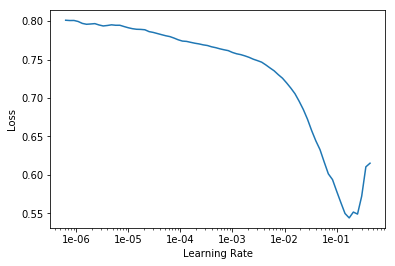

In [14]:
# we typically find the point where the slope is steepest
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.413457,0.314053,0.977800,00:12
1,0.089240,0.093998,0.982000,00:12
2,0.082152,0.104436,0.982200,00:12
3,0.079906,0.096241,0.982200,00:12
4,0.073874,0.107307,0.980400,00:11
5,0.053565,0.113010,0.979600,00:12
6,0.045306,0.117272,0.978600,00:11
7,0.049656,0.117565,0.979200,00:11
8,0.041794,0.117959,0.978800,00:11


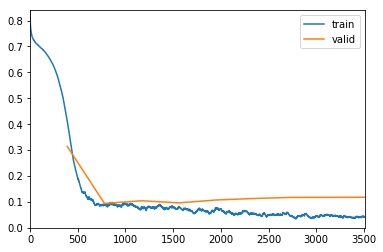

In [15]:
# Fit the model based on selected learning rate
learn.fit_one_cycle(9, max_lr=slice(1e-03))

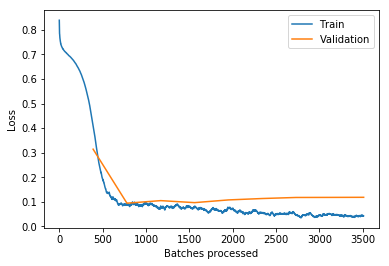

In [16]:
# Analyse our model
learn.model
learn.recorder.plot_losses()

In [17]:
# Predict our target value
predictions, *_ = learn.get_preds(DatasetType.Valid)
y_score = np.array(predictions[:,1].tolist())
y_valid = list(train_df.iloc[valid_ids].label)
gini_score(y_valid, y_score)

0.15946545132573298

In [18]:
# Predict our target value
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.array(predictions[:,1].tolist())
# create submission file to submit in Kaggle competition
submission = pd.DataFrame({'id': test_id, 'label': labels})
submission.to_csv('data/submission.csv', index=False)
submission.head()

,id,label
0,30000,0.024836
1,30001,0.020117
2,30002,0.000041
3,30003,0.009660
4,30004,0.024951
